# Doing Do-calculus

In 2006, [Shpitser and Pearl](https://ftp.cs.ucla.edu/pub/stat_ser/r327.pdf) established an algorithm for identifying causal effects with unobserved latent variables given a causal graph. A causal effect $P(y|\hat{x})$ (where $\hat{x}=do(x)$ denotes a causal intervention setting the random variable $X=x$) is **identifiable** if it can be written down in terms of observed "hat-free" variables.

In 2017, [Tikka and Karvanen](https://arxiv.org/abs/1806.07161) implemented this algorithm in the R package `causaleffect`. 

This Jupyter notebook runs in R, and uses `causaleffect`. You can set up an R jupyter notebook by following the instructions [here](https://docs.anaconda.com/anaconda/user-guide/tasks/using-r-language/).

## Installation of `causaleffect`

For first time installation of `causaleffect`, uncomment and run this cell.

In [1]:
# install.packages("BiocManager")
# library(BiocManager)
# BiocManager::install("graph")
# install.packages("ggm")

# install.packages("causaleffect", dependencies = TRUE)

In [2]:
options(repr.plot.width=6, repr.plot.height=4)

In [3]:
library("causaleffect")
library("igraph")


Attaching package: ‘causaleffect’

The following object is masked from ‘package:utils’:

    recover


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



## A simple example of an identifiable causal effect

The DAG below is an example of a causal graph where the causal effect $P(y|\hat{x})$ **is** identifiable (see Section 3.5.1 of Pearl's *Causality*)

<img src="Figures/identifiable.jpg" width="200" height="300"> 

Solid arrows denote a cause $\rightarrow$ effect relationship. The dashed double-headed arrow denotes an unobserved common cause. In `causaleffect`, we denote unobserved common causes with bidirected edges, and give them an attribue `"U"` with `set.edge.attribute`.

Construct the DAG

In [4]:
dag <- graph.formula(Z-+X, X-+Y, Z-+Y, Z-+Y, Y-+Z, simplify=FALSE)

Mark edges which are unobserved

In [5]:
dag <- set.edge.attribute(graph=dag, name = "description", index=c(4,5), value="U")

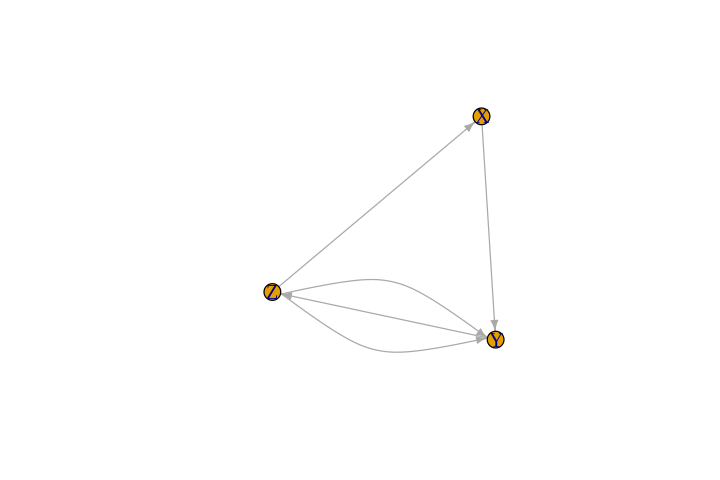

In [6]:
plot(dag)

Compute the causal effect $P(y|\hat{x})$

In [7]:
ce <- causal.effect(x="X", y="Y", z=NULL, G=dag, expr=TRUE)

In [8]:
cat(ce)

\sum_{Z}P(Y|Z,X)P(Z)

So the causal effect is

$$P(y|\hat{x}) = \sum_{Z}P(Y|Z,X)P(Z)$$

in agreement with Section 3.5.1 of Pearl's *Causality* -- this is a simple application [back-door adjustment](https://github.com/jaryaman/causal-inference-cheat-sheet/).

## A simple example of a non-identifiable causal effect

The DAG below is an example of a causal graph where the causal effect $P(y|\hat{x})$ **is not** identifiable (see Section 3.5.2 of Pearl's *Causality*)

<img src="Figures/unidentifiable.jpg" width="200" height="300"> 

A sufficient condition for unidentifiability is the existence of a confounding arc between the cause and any of its children, where those children are ancestors of the effect.

Let's see if `causaleffect` can verify that this causal effect is indeed unidentifiable

In [9]:
dag <- graph.formula(X-+Z, Z-+Y, X-+Z, Z-+X, simplify=FALSE)
dag <- set.edge.attribute(graph=dag, name = "description", index=c(3,4), value="U")

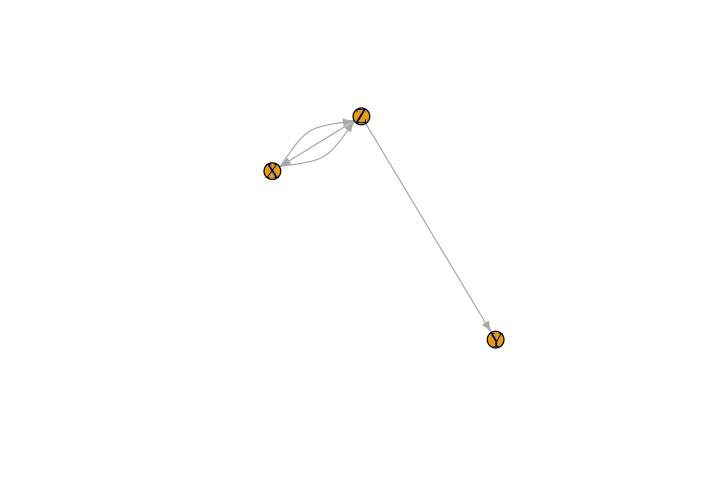

In [10]:
plot(dag)

In [11]:
ce <- causal.effect(x="X", y="Y", z=NULL, G=dag, expr=TRUE)

ERROR: Error: Not identifiable.


Great! So `causaleffect` has verified that the causal effect is unidentifiable.

## Direct effects: sex discrimination in college admission

The following example is taken from Section 4.5.3 of Pearl's *Causality*, based on a case of alleged sex bias in graduate admissions at Berkeley [(Bickel et al. 1975)](https://science.sciencemag.org/content/187/4175/398)

<img src="Figures/berkeley.jpg" width="500" height="300"> 


In [12]:
admissions <- graph.formula(X1 -+ Z, X1 -+ X2, X1 -+ Y, Z -+ X2, X2 -+ Y, Z -+ Y, Y -+ Z, simplify=FALSE)

Note that we do not directly encode $U$ here because applicant aptitude was not recorded. Rather, we represent this unobserved latent variable as a bidirected, unobserved, edge

In [14]:
admissions <- set.edge.attribute(graph=admissions, name="description", index=c(6, 7), value="U")

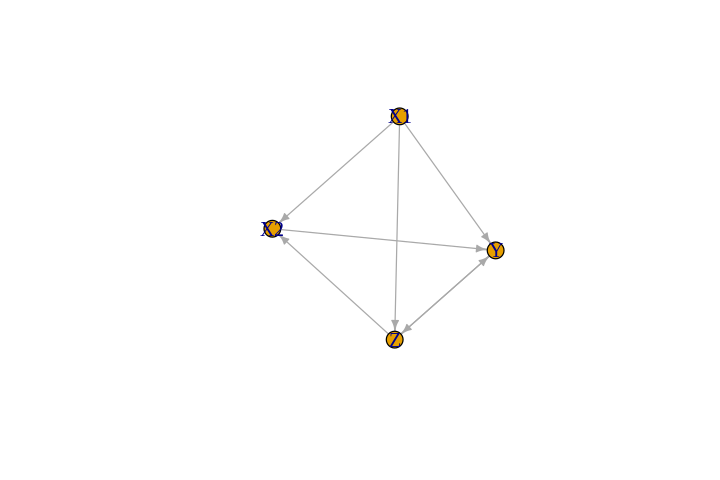

In [15]:
plot(admissions)

Say we are interested in the direct effect of $X_1$ on $Y$. The direct effect of $X$ pn $Y$ is given by 

$$P(y|\hat{x}, \hat{pa}_{Y\setminus X})$$

where $Y\setminus X$ is any realization of the parents of $Y$ excluding $X$.

In this case, the direct effect of $X_1$ on $Y$ is $P(y|\hat{x_1}, \hat{x_2})$.

In [18]:
ce <- causal.effect(x=c("X1","X2"), y="Y", z=NULL, G=admissions, expr=TRUE)

In [19]:
cat(ce)

\sum_{Z}P(Y|X1,Z,X2)P(Z|X1)

The direct effect of $X_1$ on $Y$ is therefore

$$P(y|\hat{x}_1, \hat{x}_2) = \sum_{Z}P(Y|X1,Z,X2)P(Z|X1)$$

in agreement with Section 4.5.3.

Notice that this is **quite different** to a naive adjustment for $X_2$ based on observational data, which might be

$$p(y|x_1) = \sum_{x_2} P(y|x_1,x_2)P(x_2) = E_{x_2} P(y|\hat{x}_1, x_2)$$

and a nice example of how a lack of awareness of causal reasoning when performing statistical analysis can result in erroneous conclusions.